# Восстановление золота из руды

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

<font size="4"><b>Цель проекта

Cмоделировать процесс восстановления золота из золотосодержащей руды.

<font size="4"><b>Задачи проекта

- Построить модель
- Обучить разные модели и оценить их качество кросс-валидацией
- Выберать лучшую модель и проверить её на тестовой выборке

<font size="4"><b>Исходные данные

Технологический процесс
- Rougher feed — исходное сырье
- Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
- Xanthate **— ксантогенат (промотер, или активатор флотации);
- Sulphate — сульфат (на данном производстве сульфид натрия);
- Depressant — депрессант (силикат натрия).
- Rougher process (англ. «грубый процесс») — флотация
- Rougher tails — отвальные хвосты
- Float banks — флотационная установка
- Cleaner process — очистка
- Rougher Au — черновой концентрат золота
- Final Au — финальный концентрат золота

Параметры этапов
- air amount — объём воздуха
- fluid levels — уровень жидкости
- feed size — размер гранул сырья
- feed rate — скорость подачи

Наименование признаков:<br>
[этап].[тип_параметра].[название_параметра]<br>
Пример: rougher.input.feed_ag

Возможные значения для блока [этап]:
- rougher — флотация
- primary_cleaner — первичная очистка
- secondary_cleaner — вторичная очистка
- final — финальные характеристики

Возможные значения для блока [тип_параметра]:
- input — параметры сырья
- output — параметры продукта
- state — параметры, характеризующие текущее состояние этапа
- calculation — расчётные характеристики

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from lightgbm import LGBMRegressor
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.mode.chained_assignment = None

In [3]:
try:
    df_train = pd.read_csv('D:\\Yandex_practicum\\Project_9\\gold_recovery_train_new.csv')
    df_test = pd.read_csv('D:\\Yandex_practicum\\Project_9\\gold_recovery_test_new.csv')
    df_full = pd.read_csv('D:\\Yandex_practicum\\Project_9\\gold_recovery_full_new.csv')
except: 
    df_train = pd.read_csv('/datasets/gold_recovery_train_new.csv')
    df_test = pd.read_csv('/datasets/gold_recovery_test_new.csv')
    df_full = pd.read_csv('/datasets/gold_recovery_full_new.csv')

### Общая информация о данных

In [4]:
df_train.head(5)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

In [5]:
df_test.head(5)

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,1399.001695,-499.485144,13.128569,5.636710,489.793655,62.710452,42.022440,12.084103,16.922877,6.153479,16.867518,6.150709,1001.849317,-350.301265,1249.738612,-399.107531,1249.750520,-399.396730,1198.287855,-399.488594,999.472250,-399.530962,949.566189,-398.180807,24.938200,-500.490963,14.947607,-500.013837,20.018166,-450.395995,13.987058,-449.831513,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,1399.508091,-500.416324,13.036280,5.526065,490.104534,61.961163,41.187903,11.918977,17.002532,5.999043,16.996063,6.002315,998.690785,-350.425704,1248.395457,-399.946025,1249.514451,-399.630810,1200.506459,-399.942434,1000.002114,-399.491528,950.200009,-405.787514,24.923466,-499.813963,14.930873,-500.764452,19.988503,-450.114024,14.092981,-450.059163,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,1399.497088,-499.715479,13.138412,5.426561,489.617969,66.903807,42.546294,12.091332,16.992520,5.850632,16.982096,5.853594,998.516720,-349.783538,1247.440748,-400.264330,1248.207204,-401.074405,1199.770026,-400.790582,999.925519,-399.236999,950.320481,-400.864340,24.908732,-500.304035,14.996511,-500.993821,20.039689,-450.263164,14.077881,-449.660997,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,1401.065165,-501.038738,12.400507,5.114758,476.618130,59.865919,41.060195,12.181597,16.532144,5.801935,16.515277,5.803657,1000.276604,-350.172597,1251.322675,-398.655289,1250.493702,-399.746728,1199.398691,-397.50

In [6]:
df_full.tail()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
19434,2018-08-18 06:59:59,3.224920,11.356233,6.803482,46.713954,73.755150,8.769645,3.141541,10.403181,1.529220,123.381787,8.028927,6.5,1.304232,6.559174,12.445966,7.056338,32.940215,22.854592,6.531541,3.934320,2.314352,1648.421193,-400.382169,1648.742005,-400.359661,1648.578230,-399.363624,1648.833984,-399.669220,45912.942619,2497.652954,2499.177950,1.155559,6.091855,4.617558,560.889077,85.718304,37.369774,5.335862,7.762770,9.158609,7.766744,9.156069,11.124896,10.984003,30.068876,18.603550,89.574376,4.207261,0.612935,16.666590,0.748633,1199.245914,-300.845518,1149.807890,-498.789721,1047.963596,-498.413079,946.640977,-499.152477,849.664935,-499.214461,849.758091,-497.448664,0.0,0.0,0.0,0.0,35.043205,-499.045671,29.906659,-499.979939,26.002402,-499.953431,22.987238,-499.967351,23.031497,-501.167942,20.007571,-499.740028,18.006038,-499.834374,13.001114,-500.155694,20.007840,-501.296428
19435,2018-08-18 07:59:59,3.195978,11.349355,6.862249,46.866780,69.049291,8.897321,3.130493,10.549470,1.612542,120.878188,7.962636,6.5,1.302419,6.612376,12.623947,7.542264,32.

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

In [9]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


- В данных есть пропуски
- В тестовой выборке отсутствует часть признаков

### Проверка корректности расчета эффективности обогащения

In [10]:
recovery_calc = ((df_train['rougher.output.concentrate_au'] * 
                 (df_train['rougher.input.feed_au'] - df_train['rougher.output.tail_au'])) /
                 (df_train['rougher.input.feed_au'] * 
                 (df_train['rougher.output.concentrate_au'] - df_train['rougher.output.tail_au']))) * 100

mean_absolute_error(df_train['rougher.output.recovery'], recovery_calc)

9.73512347450521e-15

- Значение MAE достаточно низкое, чтобы утверждать, что эффективность обогащения, приведенная в обучающей выборке, рассчитана верно

### Анализ признаков, недоступных в тестовой выборке

In [11]:
df_full.columns.difference(df_test.columns)

Index(['final.output.concentrate_ag', 'final.output.concentrate_au',
       'final.output.concentrate_pb', 'final.output.concentrate_sol',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_au',
       'final.output.tail_pb', 'final.output.tail_sol',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_au',
       'primary_cleaner.output.tail_pb', 'primary_cleaner.output.tail_sol',
       'rougher.calculation.au_pb_ratio',
       'rougher.calculation.floatbank10_sulfate_to_au_feed',
       'rougher.calculation.floatbank11_sulfate_to_au_feed',
       'rougher.calculation.sulfate_to_au_concentrate',
       'rougher.output.concentrate_ag', 'rougher.output.concentrate_au',
       'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol',
       'roughe

- В тестовой выборке отсутствуют признаки, характеризующие эффективность процесса обогащения

### Предобработка данных

In [12]:
df_train.isna().sum().sort_values(ascending=False)

secondary_cleaner.output.tail_sol                     1605
rougher.state.floatbank10_e_air                        436
rougher.input.floatbank11_xanthate                     428
primary_cleaner.output.concentrate_sol                 286
secondary_cleaner.state.floatbank2_a_air               217
final.output.concentrate_sol                           211
rougher.input.feed_size                                144
primary_cleaner.input.xanthate                         100
rougher.input.feed_pb                                  100
final.output.tail_pb                                   100
primary_cleaner.output.concentrate_pb                   86
rougher.input.feed_sol                                  78
primary_cleaner.output.tail_sol                         46
rougher.input.floatbank11_sulfate                       36
primary_cleaner.input.depressant                        32
rougher.input.floatbank10_sulfate                       29
rougher.output.concentrate_sol                          

In [13]:
df_test.isna().sum().sort_values(ascending=False)

rougher.input.floatbank11_xanthate            25
rougher.input.feed_sol                        21
secondary_cleaner.state.floatbank3_a_air       9
rougher.input.floatbank11_sulfate              8
primary_cleaner.input.depressant               5
rougher.input.floatbank10_sulfate              5
primary_cleaner.input.xanthate                 4
primary_cleaner.input.sulfate                  4
rougher.input.feed_rate                        3
secondary_cleaner.state.floatbank2_a_air       3
secondary_cleaner.state.floatbank2_b_air       2
rougher.input.feed_size                        1
secondary_cleaner.state.floatbank2_b_level     0
rougher.state.floatbank10_f_level              0
rougher.state.floatbank10_f_air                0
secondary_cleaner.state.floatbank3_a_level     0
secondary_cleaner.state.floatbank2_a_level     0
date                                           0
rougher.state.floatbank10_e_air                0
secondary_cleaner.state.floatbank3_b_air       0
secondary_cleaner.st

In [14]:
df_full.isna().sum().sort_values(ascending=False)

secondary_cleaner.output.tail_sol                     1748
rougher.input.floatbank11_xanthate                     453
rougher.state.floatbank10_e_air                        436
primary_cleaner.output.concentrate_sol                 370
secondary_cleaner.state.floatbank2_a_air               220
final.output.concentrate_sol                           211
rougher.input.feed_size                                145
primary_cleaner.output.concentrate_pb                  116
primary_cleaner.input.xanthate                         104
final.output.tail_pb                                   101
rougher.input.feed_pb                                  100
rougher.input.feed_sol                                  99
primary_cleaner.output.tail_sol                         62
rougher.input.floatbank11_sulfate                       44
primary_cleaner.input.depressant                        37
rougher.input.floatbank10_sulfate                       34
primary_cleaner.input.sulfate                           

Добавим в тестовую выборку целевые признаки

In [15]:
df_test = pd.merge(df_test, df_full[['date', 'rougher.output.recovery', 'final.output.recovery']], on='date', how="left")

Исключать пропуски будем после устранения выбросов

Проверим наличие дубликатов

In [16]:
df_train['date'].duplicated().sum()

0

In [17]:
df_test['date'].duplicated().sum()

0

In [18]:
df_train_cleared = df_train.drop(columns=['date'])
df_test_cleared = df_test.drop(columns=['date'])

- Пропуски будут исключены после устранения выбросов
- Проведена проверка на наличие дубликатов

## Анализ данных

In [19]:
df_test_cleared.describe()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.output.recovery,final.output.recovery
count,5286.000000,5285.000000,5290.000000,5286.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5290.000000,5290.000000,5287.000000,5289.000000,5269.000000,5290.000000,5285.000000,5290.000000,5282.000000,5265.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5287.000000,5290.000000,5288.000000,5290.000000,5281.000000,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000
mean,174.839652,8.683596,7.266339,1.383803,1.539494e+03,-497.665883,1.545174e+03,-500.273098,1.527272e+03,-498.330680,1.544844e+03,-500.199527,9.371940,3.798082,489.800620,55.951097,37.716648,9.334682,13.855759,6.467745,13.922328,6.512103,1053.400166,-395.732530,1318.926879,-475.241428,1301.595477,-474.836671,1214.847960,-475.682272,1056.648995,-469.029688,997.949719,-470.482465,26.312630,-502.750897,21.949119,-501.987097,25.402926,-507.490314,2.098211e+01,-506.627916,1.632007e+01,-505.144570,1.373544e+01,-463.349858,12.804186,-501.329122,9.881145,-495.663398,17.304935,-501.793193,84.997810,68.471462
std,43.027080,3.072050,0.610219,0.643474,1.167979e+02,19.952431,1.222246e+02,32.968307,1.225380e+02,21.964876,1.247731e+02,31.045257,1.926264,0.954859,108.036326,19.081758,5.491415,1.619521,3.350852,1.065114,3.223769,0.886989,121.139309,91.085505,156.450366,45.649466,171.269667,45.859866,185.763319,47.844967,131.542839,59.325990,128.218869,60.759318,3.429852,28.756505,4.354961,34.582722,6.526457,47.620908,6.736179e+00,44.528673,3.493583e+00,31.427337,3.430484e+00,86.189107,3.026591,17.951495,2.868205,34.535007,4.536544,39.044215,13.077651,9.513871
min,2.566156,0.003839,5.650000,0.004984,5.445860e-32,-795.316337,6.647490e-32,-799.997015,4.033736e-32,-799.960571,4.039220e-32,-799.794250,0.568441,0.273677,0.002986,0.046369,1.393488,0.568632,0.001147,0.000568,0.000077,0.006985,-0.042069,-657.949759,-0.72

In [20]:
df_train_cleared.describe()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,14148.000000,14148.000000,13938.000000,14149.000000,14149.000000,14149.000000,14049.000000,14144.000000,14149.000000,14129.000000,14117.000000,14149.000000,14049.000000,14149.000000,14063.000000,13863.000000,14149.000000,14148.000000,14134.000000,14103.000000,14149.000000,14145.000000,14148.000000,14145.000000,14148.000000,14147.000000,14148.000000,14146.000000,14148.000000,1.414800e+04,14148.000000,14148.000000,14149.000000,14149.000000,14049.000000,14141.000000,14005.000000,14071.000000,14149.000000,14120.000000,14141.000000,14113.000000,13721.000000,14149.000000,14149.000000,14127.000000,14149.000000,14149.000000,14148.000000,14149.000000,14149.000000,14149.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14149.000000,14149.000000,13713.000000,14149.000000,14149.000000,14149.000000,14147.000000,14139.000000,12544.000000,14149.000000,13932.000000,14148.000000,14128.000000,14148.000000,14145.000000,14148.000000,14148.000000,14148.000000,14143.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148

### Изменение концентрации Au, Ag, Pb на этапах

In [21]:
sns.set_style('whitegrid')

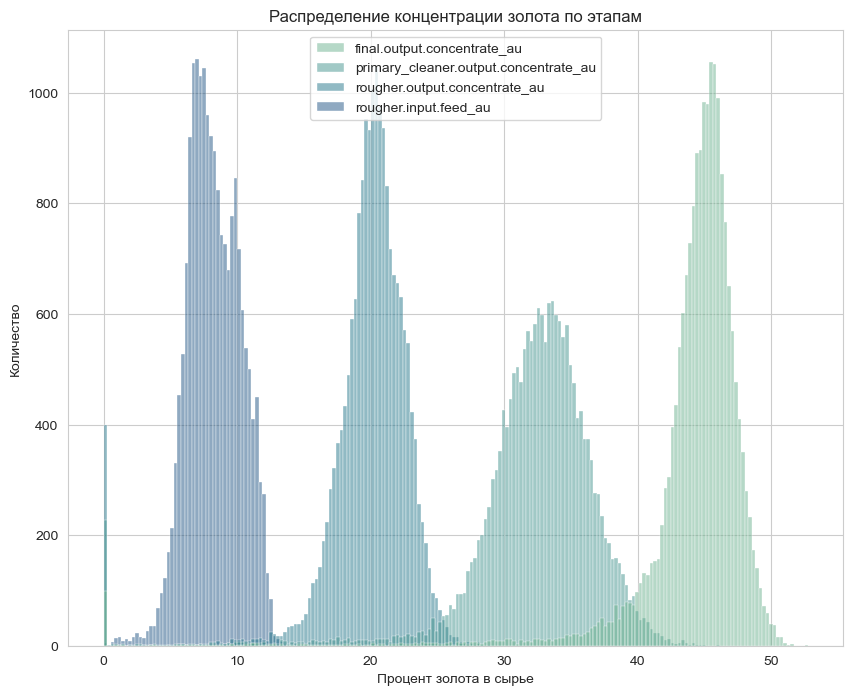

In [22]:
f, ax = plt.subplots(figsize=(10, 8))
sns.histplot(data=df_full[['final.output.concentrate_au', 
                           'primary_cleaner.output.concentrate_au',
                           'rougher.output.concentrate_au',
                           'rougher.input.feed_au']],
             bins=200, palette='crest')
ax.set_title('Распределение концентрации золота по этапам')
ax.set_xlabel('Процент золота в сырье')
ax.set_ylabel('Количество');

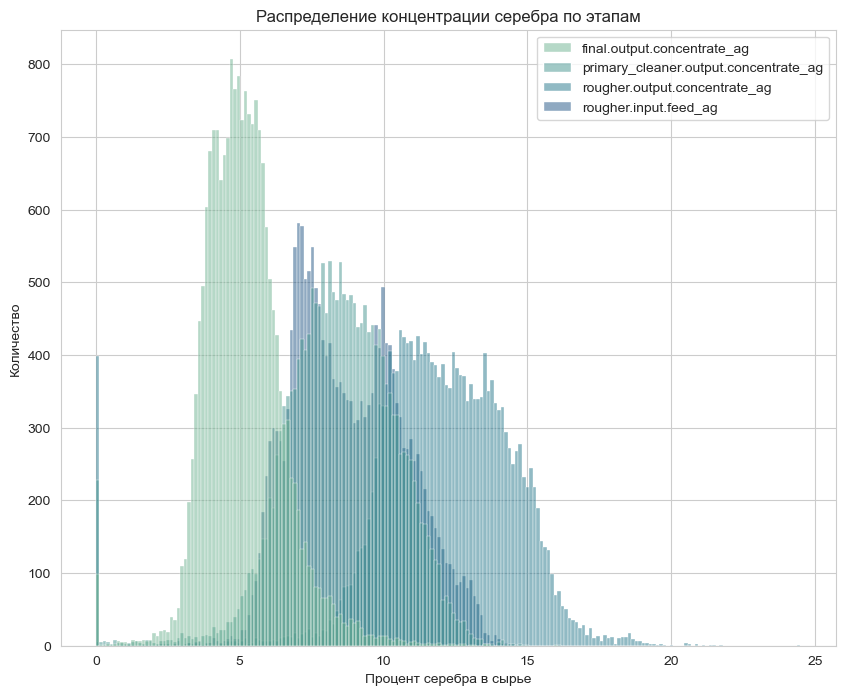

In [23]:
f, ax = plt.subplots(figsize=(10, 8))
sns.histplot(data=df_full[['final.output.concentrate_ag', 
                           'primary_cleaner.output.concentrate_ag',
                           'rougher.output.concentrate_ag',
                           'rougher.input.feed_ag']],
             bins=200, palette='crest')
ax.set_title('Распределение концентрации серебра по этапам')
ax.set_xlabel('Процент серебра в сырье')
ax.set_ylabel('Количество');

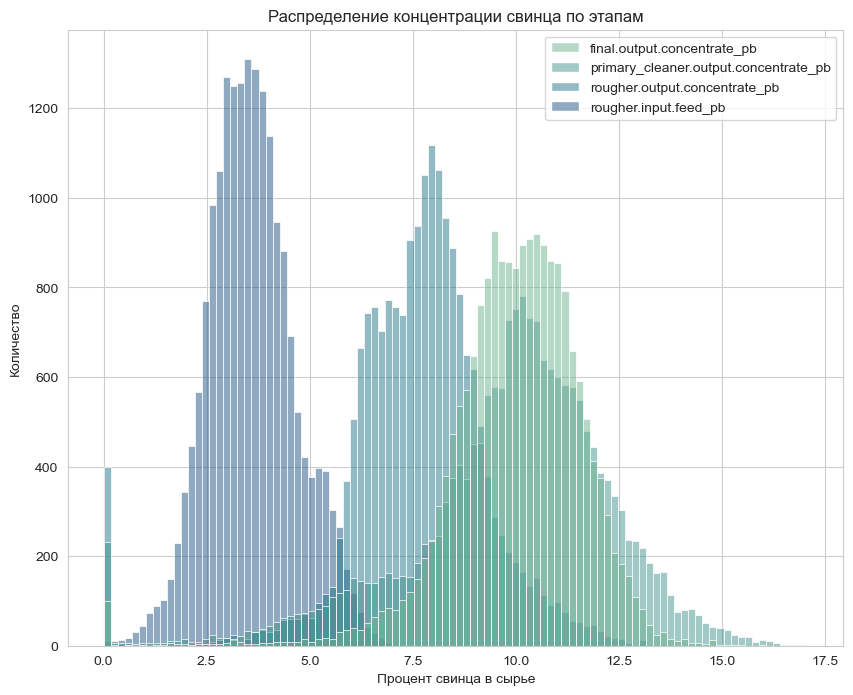

In [24]:
f, ax = plt.subplots(figsize=(10, 8))
sns.histplot(data=df_full[['final.output.concentrate_pb', 
                           'primary_cleaner.output.concentrate_pb',
                           'rougher.output.concentrate_pb',
                           'rougher.input.feed_pb']],
             bins=100, palette='crest')
ax.set_title('Распределение концентрации свинца по этапам')
ax.set_xlabel('Процент свинца в сырье')
ax.set_ylabel('Количество');

- Для золота наблюдается явная зависимость увеличения концентрации по мере очистки
- Концентрация серебра увеличивается после флотации и далее снижается по мере очистки
- Концентрация свинца увеличивается после флотации и первой очистки, далее почти не изменяется
- На всех этапах присутствуют нулевые концентрации

### Сравнение размеров гранул сырья на обучающей и тестовой выборках

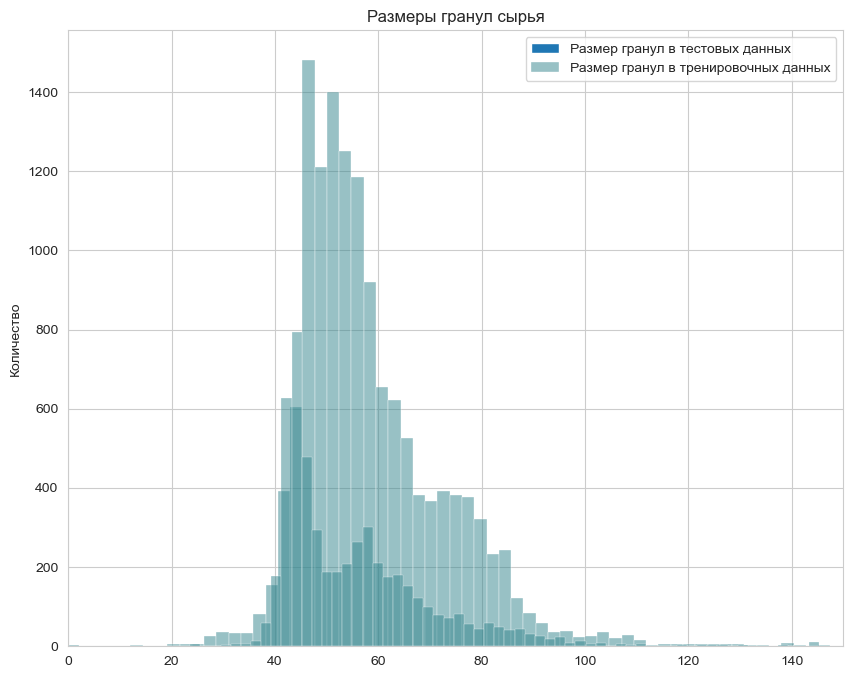

In [25]:
f, ax = plt.subplots(figsize=(10, 8))
ax = sns.histplot(data=df_train[['rougher.input.feed_size']],
             bins=200, palette='crest', legend=False)
ax = sns.histplot(data=df_test[['rougher.input.feed_size']],
             bins=200, palette='crest', legend=False)
ax.legend(['Размер гранул в тестовых данных', 'Размер гранул в тренировочных данных'])
ax.set_xlim((0,150));
ax.set_title('Размеры гранул сырья')
ax.set_ylabel('Количество');

- Распределения размеров гранул сырья на обучающей и тестовой выборках достаточно близки, хотя есть различие в районе 50

### Исследование суммарной концентрации всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах

In [26]:
sns.set_palette('crest')

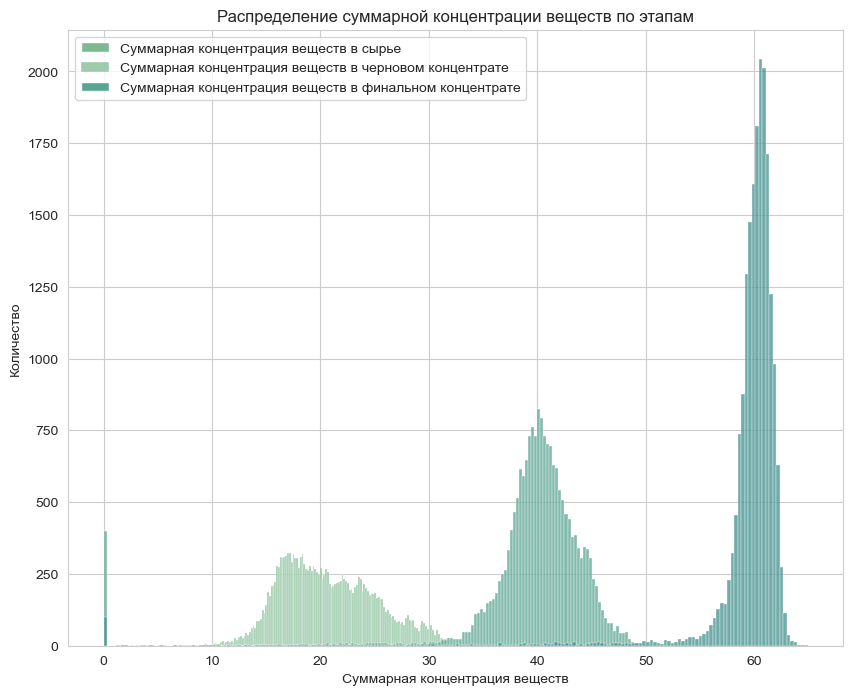

In [27]:
f, ax = plt.subplots(figsize=(10, 8))
ax = sns.histplot(data=df_full['rougher.input.feed_ag'] + df_full['rougher.input.feed_au'] +
       df_full['rougher.input.feed_pb'],
             bins=200)
ax = sns.histplot(data=df_full['rougher.output.concentrate_ag'] + df_full['rougher.output.concentrate_au'] +
       df_full['rougher.output.concentrate_pb'],
             bins=200)
ax = sns.histplot(data=df_full['final.output.concentrate_ag'] + df_full['final.output.concentrate_au'] +
       df_full['final.output.concentrate_pb'],
             bins=200);
ax.legend(['Суммарная концентрация веществ в сырье', 
           'Суммарная концентрация веществ в черновом концентрате',
           'Суммарная концентрация веществ в финальном концентрате'])
ax.set_title('Распределение суммарной концентрации веществ по этапам')
ax.set_xlabel('Суммарная концентрация веществ')
ax.set_ylabel('Количество');

Исключим из тренировочных данных признаки, которые отсутствуют в тестовой выборке

In [28]:
df_train_cleared.drop(columns=df_train_cleared.columns.difference(df_test_cleared.columns), inplace=True)

Исключим выбросы из тренировочных и тестовых данных.

In [29]:
df_train_cleared = df_train_cleared[df_train_cleared > df_train_cleared.quantile(0.001)].dropna()
df_test_cleared = df_test_cleared[df_test_cleared > df_test_cleared.quantile(0.001)].dropna()

In [30]:
#check
print(df_train_cleared.shape)
print(df_test_cleared.shape)

(12036, 54)
(4865, 54)


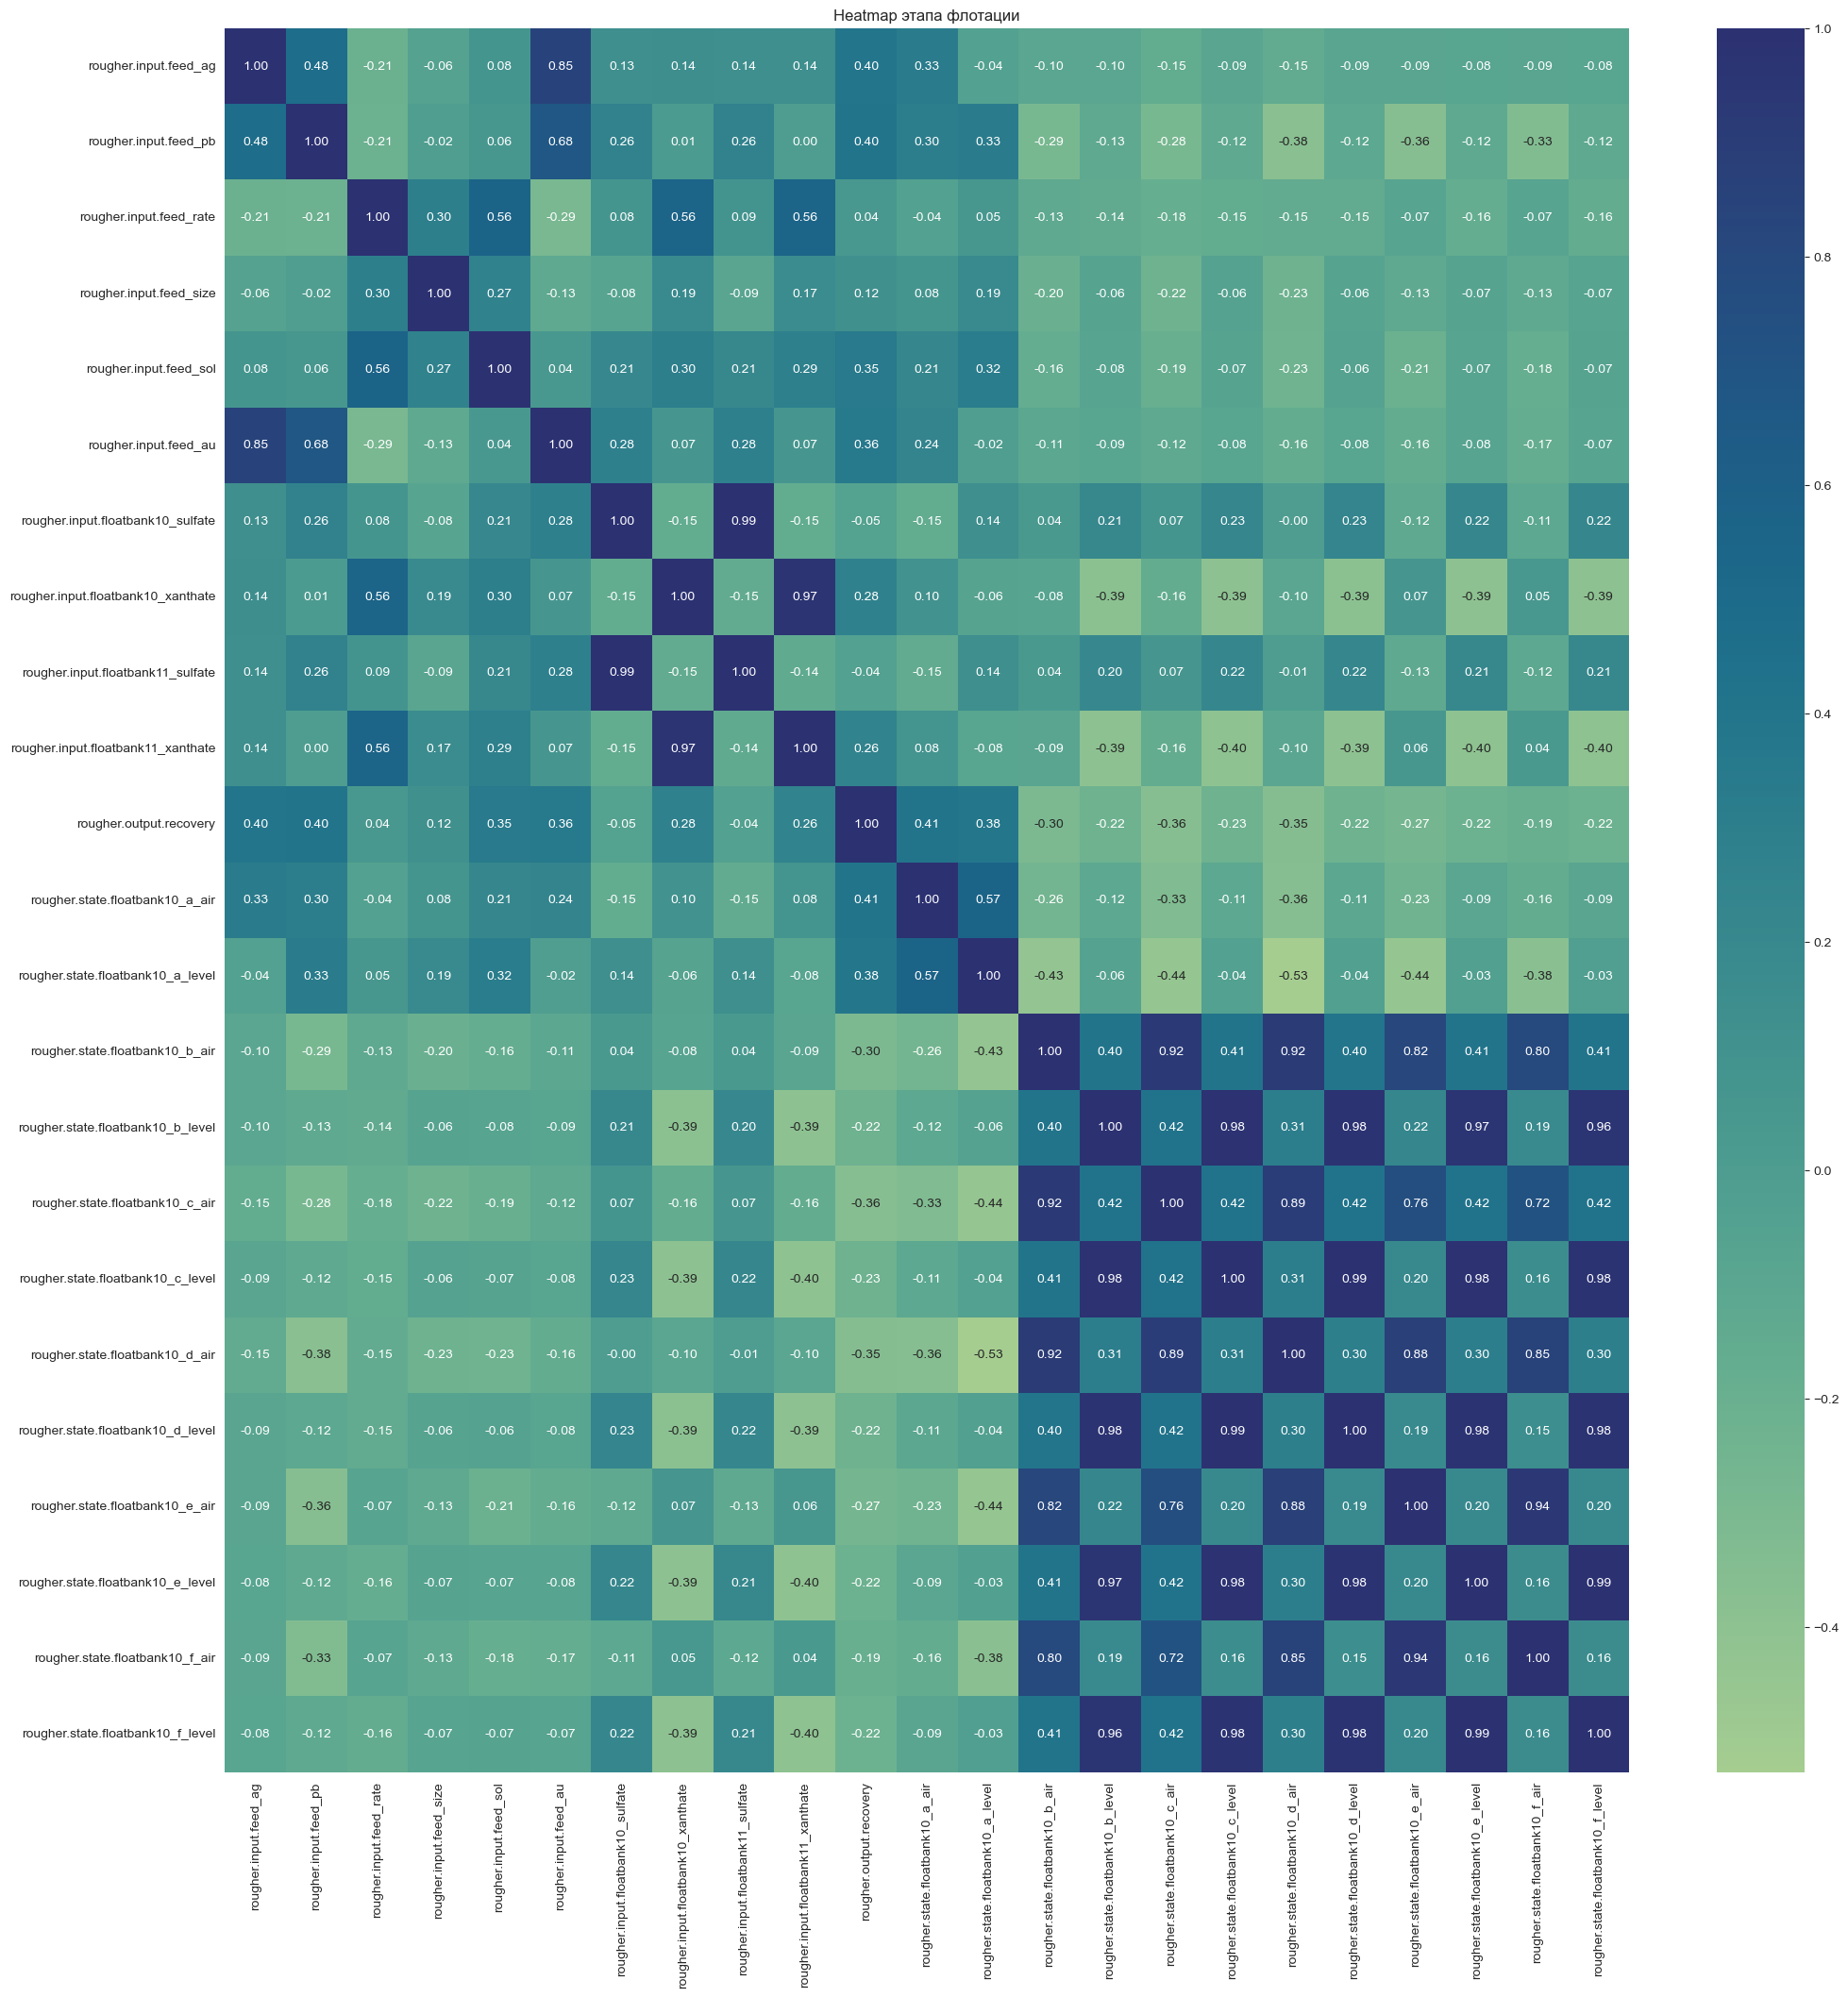

In [31]:
plt.figure(figsize=(24, 24))
ax = sns.heatmap(df_train_cleared.loc[:, df_train_cleared.columns.str.contains('rougher')].corr(), 
            annot=True, fmt='.2f', cmap='crest', cbar=True)
ax.set_title('Heatmap этапа флотации');

In [32]:
df_train_cleared.loc[:, df_train_cleared.columns.str.contains('rougher')].corr()['rougher.output.recovery'].sort_values(ascending=False)

rougher.output.recovery               1.000000
rougher.state.floatbank10_a_air       0.410163
rougher.input.feed_pb                 0.403758
rougher.input.feed_ag                 0.400185
rougher.state.floatbank10_a_level     0.382585
rougher.input.feed_au                 0.357028
rougher.input.feed_sol                0.348073
rougher.input.floatbank10_xanthate    0.282066
rougher.input.floatbank11_xanthate    0.258617
rougher.input.feed_size               0.124209
rougher.input.feed_rate               0.044311
rougher.input.floatbank11_sulfate    -0.044555
rougher.input.floatbank10_sulfate    -0.050429
rougher.state.floatbank10_f_air      -0.192463
rougher.state.floatbank10_f_level    -0.218422
rougher.state.floatbank10_e_level    -0.220511
rougher.state.floatbank10_b_level    -0.224876
rougher.state.floatbank10_d_level    -0.224903
rougher.state.floatbank10_c_level    -0.225420
rougher.state.floatbank10_e_air      -0.266718
rougher.state.floatbank10_b_air      -0.304488
rougher.state

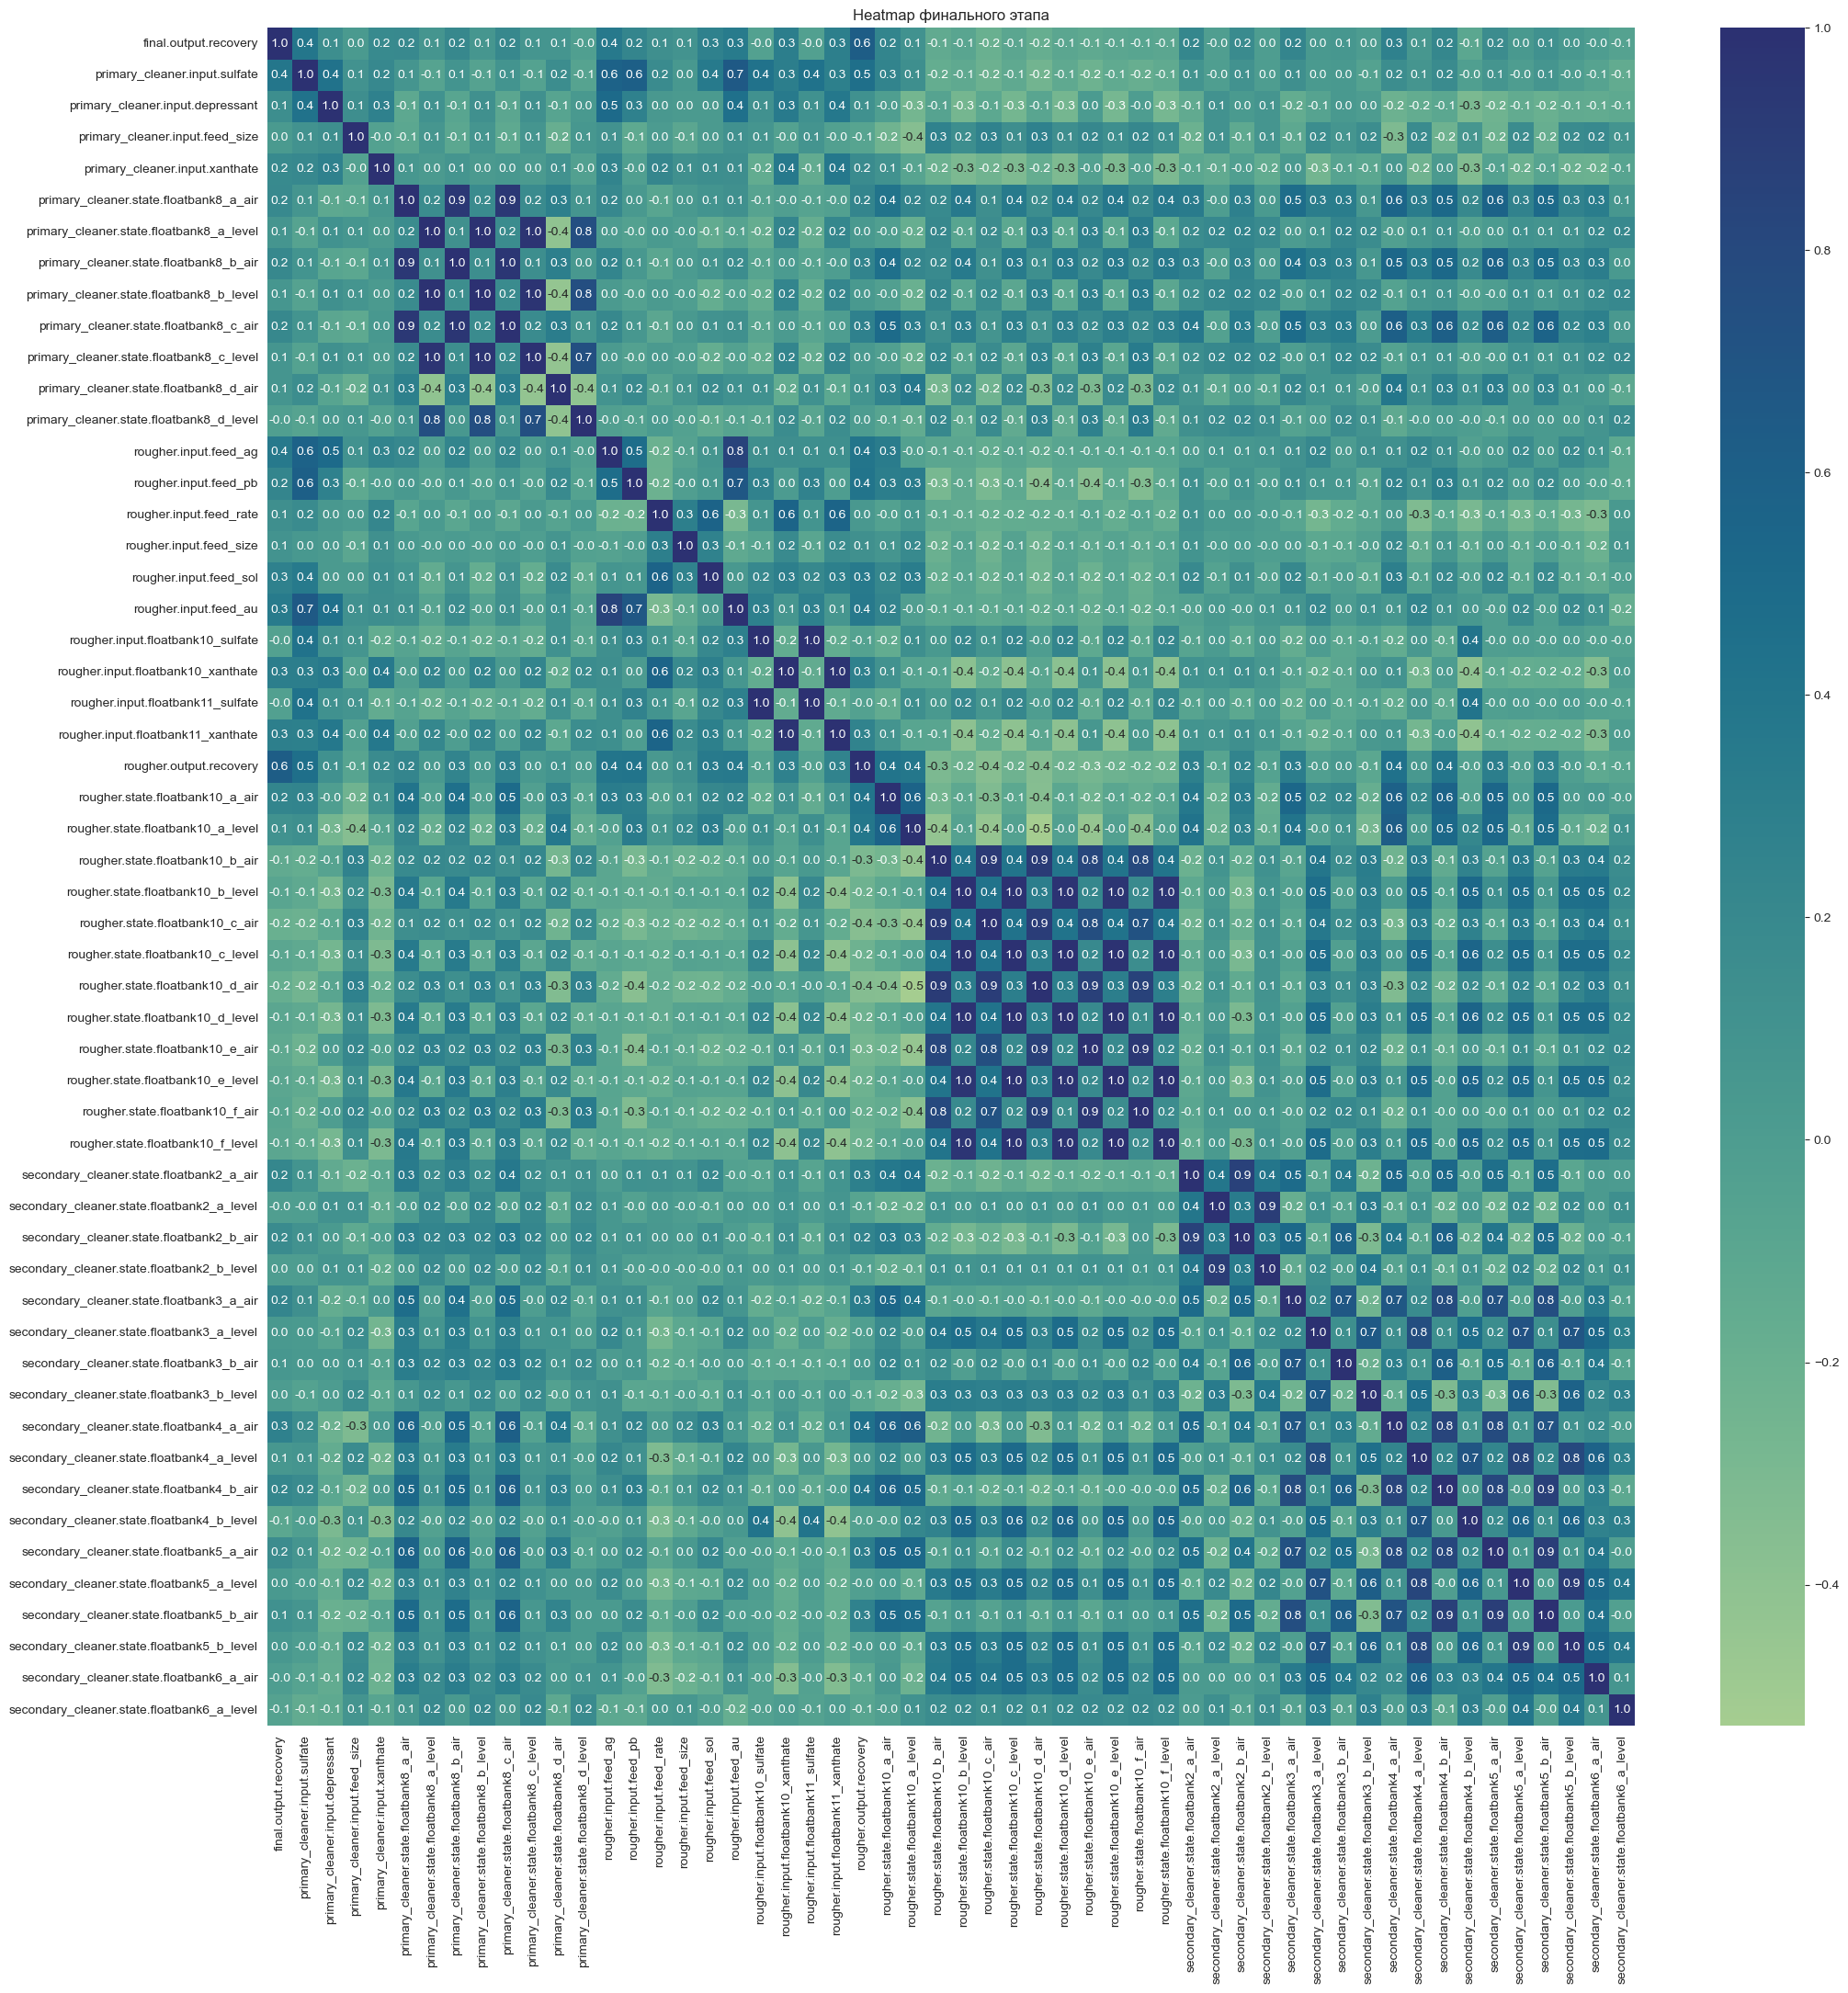

In [33]:
plt.figure(figsize=(24, 24))
ax = sns.heatmap(df_train_cleared.corr(), annot=True, fmt='.1f', cmap='crest', cbar=True)
ax.set_title('Heatmap финального этапа');

In [34]:
df_train_cleared.corr()['final.output.recovery'].sort_values(ascending=False)

final.output.recovery                         1.000000
rougher.output.recovery                       0.621161
primary_cleaner.input.sulfate                 0.389831
rougher.input.feed_ag                         0.358267
rougher.input.feed_au                         0.343673
rougher.input.floatbank10_xanthate            0.311258
rougher.input.floatbank11_xanthate            0.299320
rougher.input.feed_sol                        0.279625
secondary_cleaner.state.floatbank4_a_air      0.274076
rougher.state.floatbank10_a_air               0.240740
rougher.input.feed_pb                         0.234160
secondary_cleaner.state.floatbank3_a_air      0.232490
secondary_cleaner.state.floatbank4_b_air      0.224299
secondary_cleaner.state.floatbank2_a_air      0.221697
primary_cleaner.state.floatbank8_c_air        0.211094
primary_cleaner.state.floatbank8_b_air        0.208305
primary_cleaner.state.floatbank8_a_air        0.197024
primary_cleaner.input.xanthate                0.191226
secondary_

В данных есть мультиколлинеарность, устранять ее не будем, тк существенного влияния она на результаты не оказывает 

## Модель

### Функция вычисления sMAPE

In [35]:
def smape(y_true, y_pred):
    return 100 * np.mean(np.abs(y_true - y_pred) / ((np.abs(y_pred) + np.abs(y_true)) / 2))

smape_scorer = make_scorer(smape, greater_is_better=False)

In [36]:
def smape_final(smape_r, smape_f):
    return 0.25 * smape_r + 0.75 * smape_f

### Выделение признаков и целевых признаков на обучающей и тестовой выборках

Процесс флотации будем моделировать отдельно. Для обучения будем использовать признаки, характеризующие состояние и исходные данные технологического процесаа - input и state

In [37]:
features_train_rougher = df_train_cleared.loc[:, df_train_cleared.columns.str.contains('rougher.[i|s]')]

Функция для добавления дополнительных признаков для этапа флотации

In [38]:
def feature_rougher(data):
    
    data['var_10b_10c_10d_air'] = data[['rougher.state.floatbank10_b_air',
                                        'rougher.state.floatbank10_c_air',
                                        'rougher.state.floatbank10_d_air']].apply(np.var, axis=1)
    
    data['var_10e_10f_air'] = data[['rougher.state.floatbank10_e_air',
                                    'rougher.state.floatbank10_f_air']].apply(np.var, axis=1)
    
    data['au_to_pb_ratio'] = data['rougher.input.feed_au'] / data['rougher.input.feed_pb']
    
    data['au_to_ag_ratio'] = data['rougher.input.feed_au'] / data['rougher.input.feed_ag']
    
    data['size_to_rate'] = data['rougher.input.feed_size'] / data['rougher.input.feed_rate']
    
    data['var_10_11_sulfate'] = data[['rougher.input.floatbank10_sulfate',
                                      'rougher.input.floatbank11_sulfate']].apply(np.var, axis=1)
    
    data['var_10_11_xanthate'] = data[['rougher.input.floatbank10_xanthate',
                                       'rougher.input.floatbank11_xanthate']].apply(np.var, axis=1)
    
    return data

In [39]:
features_train_rougher = feature_rougher(features_train_rougher)

In [40]:
features_train_rougher.shape

(12036, 29)

In [41]:
target_train_rougher = df_train_cleared['rougher.output.recovery']

In [42]:
target_train_rougher.shape

(12036,)

Выделим признаки в тестовой выборке для процесса флотации

In [43]:
features_test_rougher = df_test_cleared.loc[:, df_test_cleared.columns.str.contains('rougher.[i|s]')]

In [44]:
features_test_rougher = feature_rougher(features_test_rougher)

In [45]:
features_test_rougher.shape

(4865, 29)

In [46]:
target_test_rougher = df_test_cleared['rougher.output.recovery']

In [47]:
target_test_rougher.shape

(4865,)

Выделим признаки для всего процесса. Для обучения будем использовать признаки, характеризующие состояние и исходные данные технологического процеса - input и state

In [48]:
features_train_final = df_train_cleared.loc[:, df_train_cleared.columns.str.contains('input|state')]

In [49]:
features_train_final.shape

(12036, 52)

Функция для добавления дополнительных признаков для всего процесса

In [50]:
def feature_final(data):
    
    data['var_8a_8b_8c_8d_air'] = data[['primary_cleaner.state.floatbank8_a_air',
                                        'primary_cleaner.state.floatbank8_b_air',
                                        'primary_cleaner.state.floatbank8_c_air',
                                        'primary_cleaner.state.floatbank8_d_air']].apply(np.var, axis=1)
    
    data['var_2b_3a_3b_air'] = data[['secondary_cleaner.state.floatbank2_b_air',
                                     'secondary_cleaner.state.floatbank3_a_air',
                                     'secondary_cleaner.state.floatbank3_b_air']].apply(np.var, axis=1)
    
    data['var_4a_5b_air'] = data[['secondary_cleaner.state.floatbank4_a_air',
                                  'secondary_cleaner.state.floatbank5_b_air']].apply(np.var, axis=1)
    
   
    data['delta1'] = data['secondary_cleaner.state.floatbank2_a_air'] - data['secondary_cleaner.state.floatbank2_b_air']
    data['delta2'] = data['secondary_cleaner.state.floatbank4_a_air'] - data['secondary_cleaner.state.floatbank4_b_air']
    data['delta3'] = data['secondary_cleaner.state.floatbank4_b_air'] - data['secondary_cleaner.state.floatbank5_a_air']
    data['delta4'] = data['secondary_cleaner.state.floatbank5_a_air'] - data['secondary_cleaner.state.floatbank5_b_air']
    
    data['var_delta_2b_4b_5a_5b_air'] = data[['delta1', 'delta2', 'delta3', 'delta4']].apply(np.var, axis=1)
    
    data.drop(columns=['delta1', 'delta2', 'delta3', 'delta4'], inplace=True)
       
    data['au_to_pb_ratio'] = data['rougher.input.feed_au'] / data['rougher.input.feed_pb']
    
    data['au_to_ag_ratio'] = data['rougher.input.feed_au'] / data['rougher.input.feed_ag']
        
    data['au_to_sulfate_ratio'] = data['rougher.input.feed_au'] / data['primary_cleaner.input.sulfate']
      
    data['au_to_depressant_ratio'] = data['rougher.input.feed_au'] / data['primary_cleaner.input.depressant']
   
    return data

In [51]:
features_train_final = feature_final(features_train_final)

In [52]:
features_train_final.shape

(12036, 60)

Для обучения модели будем использовать эффективность процесса флотации, при тестировании будем использовать значения эффективности, предсказанные при моделировании процесса флотации

In [53]:
features_train_final = pd.concat([features_train_final, df_train_cleared['rougher.output.recovery']], axis=1)

In [54]:
target_train_final = df_train_cleared['final.output.recovery']

In [55]:
target_train_final.shape

(12036,)

In [56]:
features_test_final = df_test_cleared.loc[:, df_test_cleared.columns.str.contains('input|state')]

In [57]:
features_test_final = feature_final(features_test_final)

In [58]:
features_test_final.shape

(4865, 60)

In [59]:
target_test_final = df_test_cleared['final.output.recovery']

In [60]:
target_test_final.shape

(4865,)

### Модель Nearest Neighbors Regression

In [61]:
pipe_knr = Pipeline([('scaler', StandardScaler()),
                     ('knr', KNeighborsRegressor(metric='euclidean', n_jobs=12, weights='distance'))])

In [62]:
param_dist = {'knr__n_neighbors' : np.random.randint(150, 200, size=20),
              'knr__algorithm' : ['brute', 'ball_tree', 'kd_tree'], 
              'knr__leaf_size' : np.random.randint(5, 50, size=10),
              'scaler' : (StandardScaler(), MinMaxScaler())}

search_knr = RandomizedSearchCV(estimator=pipe_knr,
                                param_distributions=param_dist,
                                n_iter=100,
                                scoring=smape_scorer,
                                refit=True,
                                random_state=27,
                                n_jobs=1,
                                pre_dispatch=4,
                                verbose=1)

In [63]:
search_knr.fit(features_train_rougher, target_train_rougher);

Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [64]:
pd.DataFrame(search_knr.best_params_.values(), 
             index=search_knr.best_params_.keys(),
             columns=['best_params'])

,best_params
scaler,MinMaxScaler()
knr__n_neighbors,196
knr__leaf_size,41
knr__algorithm,brute


In [65]:
print(f'Лучшая метрика на кросс-валидации для этапа флотации - {-search_knr.best_score_:0.3f}')

Лучшая метрика на кросс-валидации для этапа флотации - 5.526


In [66]:
smape_knr_r_cv = abs(search_knr.best_score_)

In [67]:
model_knr_rougher = search_knr.best_estimator_

In [68]:
search_knr.fit(features_train_final, target_train_final);

Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [69]:
pd.DataFrame(search_knr.best_params_.values(), 
             index=search_knr.best_params_.keys(),
             columns=['best_params'])

,best_params
scaler,StandardScaler()
knr__n_neighbors,150
knr__leaf_size,41
knr__algorithm,kd_tree


In [70]:
print(f'Лучшая метрика на кросс-валидации для всего процесса - {-search_knr.best_score_:0.3f}')

Лучшая метрика на кросс-валидации для всего процесса - 8.266


In [71]:
smape_knr_f_cv = abs(search_knr.best_score_)

In [72]:
model_knr_final = search_knr.best_estimator_

In [73]:
print(f'sMAPE на кросс-валидации {smape_final(smape_knr_r_cv, smape_knr_f_cv)}')

sMAPE на кросс-валидации 7.580985502722612


### Модель LGBM

In [74]:
param_dist = {'n_estimators' : np.arange(300, 800, 25),
              'max_depth' : np.arange(10, 25, 1),
              'num_leaves' : np.arange(10, 25, 1),
              'learning_rate' : np.linspace(1e-4, 1e-1, 20)}
                   
search_lgbm = RandomizedSearchCV(estimator=LGBMRegressor(boosting_type='gbdt', 
                                                         random_state=27,
                                                         n_jobs=12),
                                 param_distributions=param_dist,
                                 n_iter=150,
                                 scoring=smape_scorer,
                                 refit=True,
                                 random_state=27,
                                 n_jobs=-1,
                                 verbose=1)

In [75]:
search_lgbm.fit(features_train_rougher, target_train_rougher);

Fitting 5 folds for each of 150 candidates, totalling 750 fits


In [76]:
pd.DataFrame(search_lgbm.best_params_.values(), 
             index=search_lgbm.best_params_.keys(),
             columns=['best_params'])

,best_params
num_leaves,11.000000
n_estimators,650.000000
max_depth,14.000000
learning_rate,0.010616


In [77]:
print(f'Лучшая метрика на кросс-валидации для этапа флотации - {-search_lgbm.best_score_:0.3f}')

Лучшая метрика на кросс-валидации для этапа флотации - 5.343


In [78]:
smape_lgbm_r_cv = abs(search_lgbm.best_score_)

In [79]:
lgbm_fip = pd.DataFrame(data=search_lgbm.best_estimator_.feature_importances_,
                        index=search_lgbm.best_estimator_.feature_name_,
                        columns=['fip'])

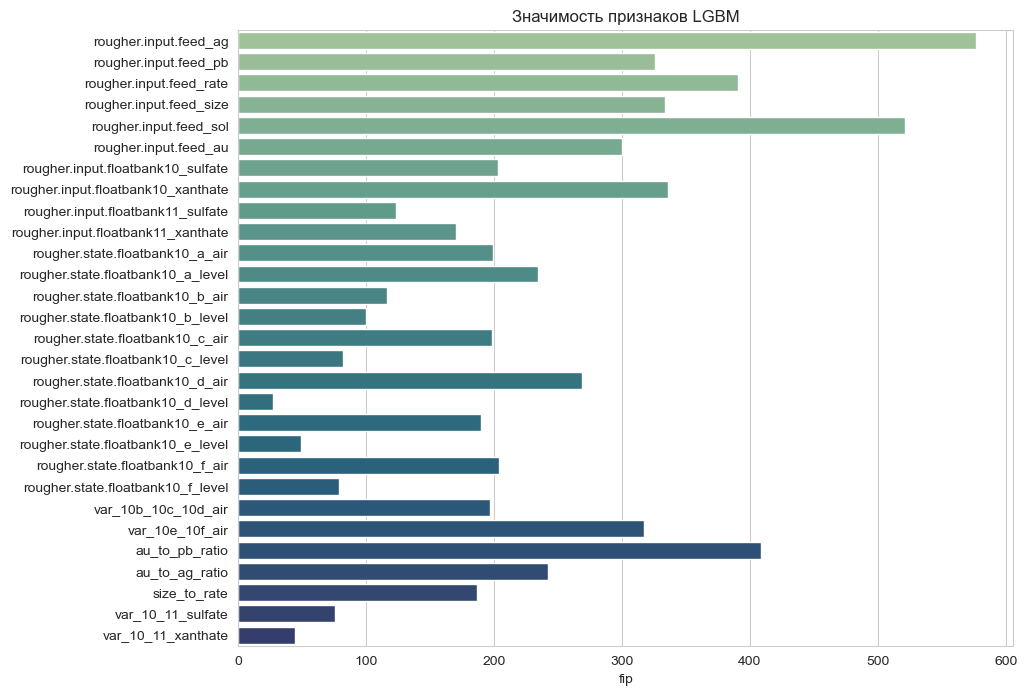

In [80]:
plt.figure(figsize=(10, 8))
sns.barplot(data=lgbm_fip, x='fip', y=lgbm_fip.index, palette='crest');
plt.title('Значимость признаков LGBM');

In [81]:
model_lgbm_rougher = search_lgbm.best_estimator_

In [82]:
search_lgbm.fit(features_train_final, target_train_final);

Fitting 5 folds for each of 150 candidates, totalling 750 fits


In [83]:
pd.DataFrame(search_lgbm.best_params_.values(), 
             index=search_lgbm.best_params_.keys(),
             columns=['best_params'])

,best_params
num_leaves,12.000000
n_estimators,425.000000
max_depth,21.000000
learning_rate,0.005358


In [84]:
print(f'Лучшая метрика на кросс-валидации для всего процесса - {-search_lgbm.best_score_:0.3f}')

Лучшая метрика на кросс-валидации для всего процесса - 7.582


In [85]:
smape_lgbm_f_cv = abs(search_lgbm.best_score_)

In [86]:
lgbm_fip = pd.DataFrame(data=search_lgbm.best_estimator_.feature_importances_,
                        index=search_lgbm.best_estimator_.feature_name_,
                        columns=['fip'])

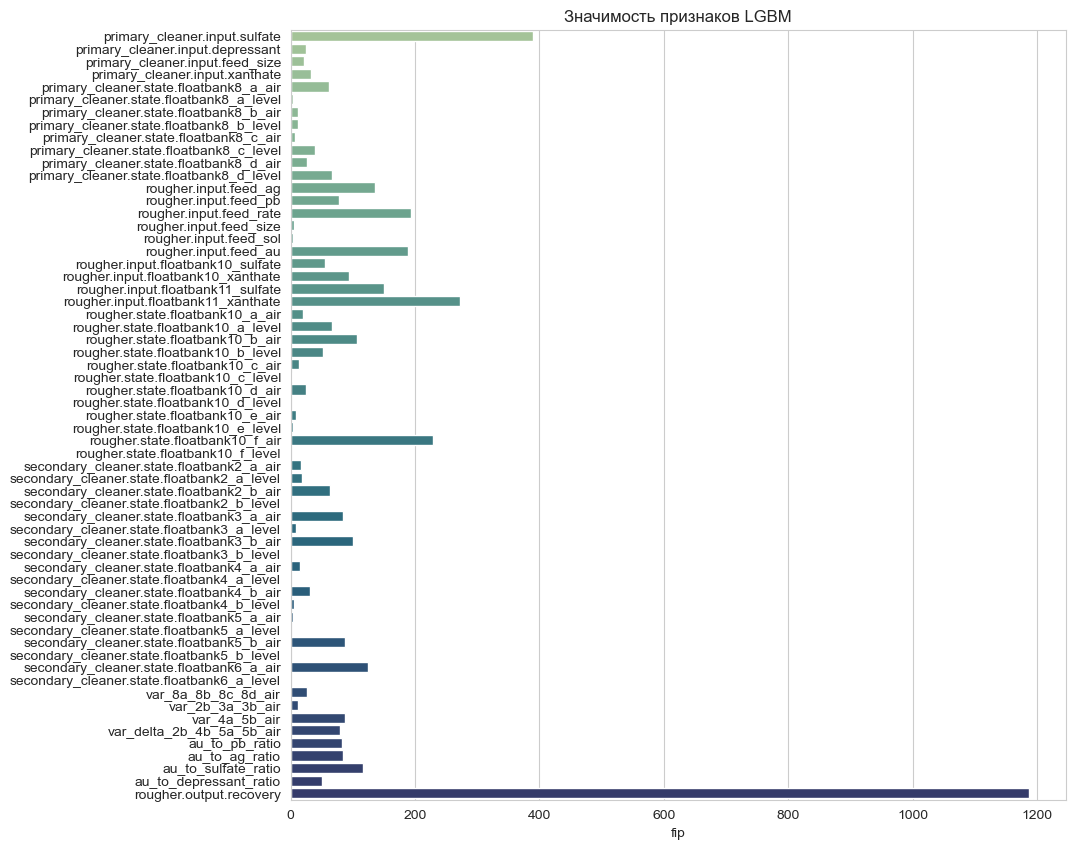

In [87]:
plt.figure(figsize=(10, 10))
sns.barplot(data=lgbm_fip, x='fip', y=lgbm_fip.index, palette='crest');
plt.title('Значимость признаков LGBM');

In [88]:
print(f'sMAPE на кросс-валидации {smape_final(smape_lgbm_r_cv, smape_lgbm_f_cv)}')

sMAPE на кросс-валидации 7.022230568575855


In [89]:
model_lgbm_final = search_lgbm.best_estimator_

### Тестирование модели

Лучшие результаты показала модель LGBM

In [90]:
predictions_rougher = model_lgbm_rougher.predict(features_test_rougher)

In [91]:
print(f'Метрика для процесса флотации {smape(target_test_rougher, predictions_rougher):0.3f}')

Метрика для процесса флотации 3.434


In [92]:
features_test_final['rougher.output.recovery'] = predictions_rougher

In [93]:
predictions_final = model_lgbm_final.predict(features_test_final)

In [94]:
print(f'Метрика для процесса всего процесса {smape(target_test_final, predictions_final):0.3f}')

Метрика для процесса всего процесса 6.725


In [95]:
print(f'Итоговая метрика \
{smape_final(smape(target_test_rougher, predictions_rougher), smape(target_test_final, predictions_final)):0.3f}')

Итоговая метрика 5.903


Чтобы оценить качество модели, сравним ее с константной моделью

In [96]:
dummy_rougher = DummyRegressor().fit(features_train_rougher, target_train_rougher)
dummy_final = DummyRegressor().fit(features_train_final, target_train_final)

In [97]:
pred_const_r = dummy_rougher.predict(features_test_rougher)

In [98]:
pred_const_f = dummy_final.predict(features_test_final)

In [99]:
print(f'Метрика для процесса флотации {smape(target_test_rougher, pred_const_r):0.3f}')

Метрика для процесса флотации 5.177


In [100]:
print(f'Метрика для процесса всего процесса {smape(target_test_final, pred_const_f):0.3f}')

Метрика для процесса всего процесса 8.140


In [101]:
print(f'Итоговая метрика DummyRegressor \
{smape_final(smape(target_test_rougher, pred_const_r), smape(target_test_final, pred_const_f)):0.3f}')

Итоговая метрика DummyRegressor 7.400


- Итоговое значение sMAPE на тестовой выборке - 5.9
- Обученная модель LGBMRegressor показывает лучшие результаты, чем константная
- Дополнительные признаки дали порядка 0.15 прироста к итоговой метрике smape
- Использование в качестве признака для моделирования финального процесса предсказаний<br>
модели процесса флотации дало порядка 0.35 прироста к итоговой метрике smape
- Результаты сильно зависят от предобратки данных.<br>
Вероятно можно улучшить итоговую метрику более тщательной подготовкой данных<br>
(выравниванием распределений размеров гранул сырья у тренировочной и тестовой выборок,<br>
"индивидуальным" подходом к устранению выбросов, вместо отсечения по квартилю).